In [69]:
import numpy as np
import astropy 
from astropy import constants as c
from astropy import units as u
import scipy.integrate as integrate
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from astropy.io import ascii
import emcee as emcee
from astropy import constants, units
import os
import corner
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde

from model_functions import *

## Model Setup

In [24]:

# Constants
pi = np.pi

# Function to calculate B_v(T) (Planck function approximation)
def B_v(T, v):

    h = 6.626e-34  # Planck's constant (Joule-second)
    k = 1.381e-23  # Boltzmann constant (Joule/Kelvin)
    c = 3e8  # Speed of light (m/s) 
    

    return (2 * h * v**3 / c**2) / (np.exp(h * v / (k * T)) - 1)

# Function to calculate tau_v
def tau_v(kappa_0, v, v_0, beta, Sigma):
    return kappa_0 * (v / v_0)**beta * Sigma

# Function to calculate the integrand B_v(T) * (1 - exp(-tau_v))
def integrand(r, T0, v, kappa_0, v_0, beta, Sigma_function):

    ## in grams / cm^2
    Sigma_r = Sigma_function(r)

    ## dimensionless
    tau = tau_v(kappa_0, v, v_0, beta, Sigma_r)

    # in kelvin
    temp = T0 * (r)**(-3/7)

    Bv  =  B_v(temp, v)

    Bv_scaled_to_au = Bv * (1/6.68459e-12)**2

    return Bv_scaled_to_au * (1 - np.exp(-tau)) * 2 * pi * r

# Define Sigma(r) as a simple function of r (e.g., power law or exponential decay)
def Sigma_function(r, Sigma0, A1=3, sigma1=15, A2=.2, r_bump=100, sigma2=8):
    gaussian1 = A1 * np.exp(-r**2 / (2 * sigma1**2))
    gaussian2 = A2 * np.exp(-(r - r_bump)**2 / (2 * sigma2**2))
    baseline = 10**(-2)

    full = gaussian1 + gaussian2 + baseline

    return full * Sigma0

# Main function to compute S_v
def S_v(i, d, R, T0, v, kappa_0, v_0, beta, Sigma0, Sigma_function, num_points=1000):

    sigma_func = lambda r: Sigma_function(r, Sigma0)
    integrand_func = lambda r: integrand(r, T0, v, kappa_0, v_0, beta, sigma_func)
    
    # Use quad for integration over r from 0 to R
    integral, error = integrate.quad(integrand_func, 0, R)
    
    cos_i = np.cos(i)
    return (cos_i / d**2) * integral

Text(0, 0.5, '$\\Sigma$ [g cm^(-2)]')

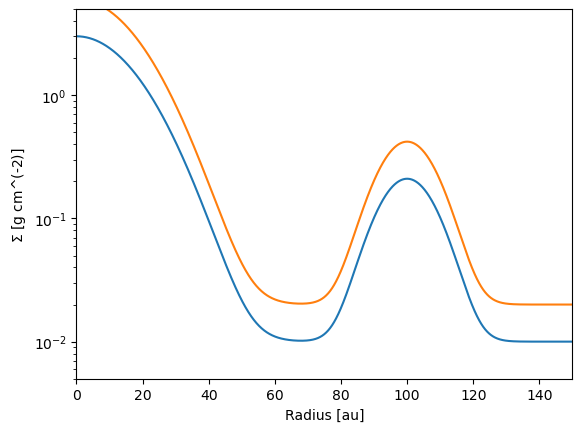

In [26]:
## check sigma function

r = np.arange(0,150,.1)
plt.plot(r, Sigma_function(r,1))
plt.plot(r, Sigma_function(r,2))


plt.yscale('log')
plt.ylim(5*10**(-3),5)
plt.xlim(0,150)
plt.xlabel('Radius [au]')
plt.ylabel(r'$\Sigma$ [g cm^(-2)]')

In [206]:
# parameter customizer

def model_wrapper(T=80,beta=1.4, Sigma0= 1, kappa_0 = 0.6, vs = np.linspace(10, 5*999, int((1000-1)/0.99))):

    # convert to hz
    vs = vs * 10**9

    i = np.radians(45)  # 45 degrees inclination
    d = 450 * 9.461e+15  # Distance in meters
    L_star = 22 # in solar lums
    M_star = 2 # in solar mass


    R = 100  # Radius limit in arbitrary units

    T0 = T * (L_star/0.28)**(2/7) / (M_star/0.8)**(1/7)  # Temperature in Kelvin

    v_0 = 33*10**9  # Reference frequency in Hz

    # vs in Hz
    Sv = []

    for v in vs:
        # Compute S_v
        S_v_value = S_v(i, d, R, T0, v, kappa_0, v_0, beta, Sigma0, Sigma_function)

        ## convert to microjansky
        S_v_value = S_v_value / 10**(-32)


        Sv.append(S_v_value)
    
    return np.array(Sv), vs


In [209]:
## check outputs for different parameters
def plot_model(ax, beta=1.4, T=80, S0 = 1,kappa0 = 0.6, vs = np.linspace(10, 5*999, int((1000-1)/0.99))):

    Sv, new_vs = model_wrapper(T=T, beta= beta, Sigma0 = S0, kappa_0 = kappa0, vs=vs)

    # vus = vs/(10**9)

    ax.plot(vs, Sv, label=f'temp {T}')
    # ax.plot(vus, vus**(2+beta) * Sv[0], label='nu ** beta + 2')

    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

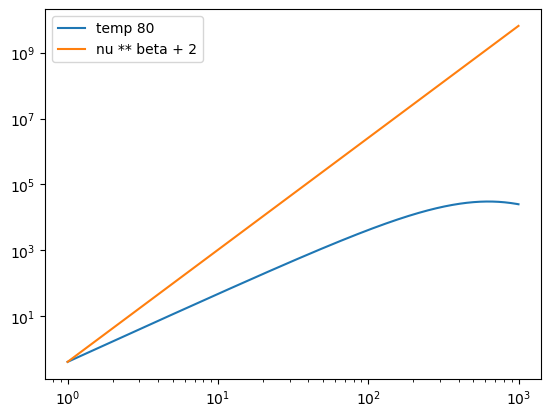

In [123]:
fig, ax = plt.subplots(1,1)
plot_model(ax)


## Fitting Data

In [169]:
# load data

## load data

# define data directories

def get_data_version(file_type, archive,file_number,non_vla_freq_index_cutoff, lower_freq_cutoff=0):
    dir_name = '/Users/calebpainter/Downloads/Research/THESIS/data'
    image_files = os.listdir(dir_name + '/image')

    # non-VLA archival
    non_vla = ascii.read(dir_name+'/MWC480.spec.txt')  
    lambda_non_vla, snu_non_vla, snu_err_non_vla = non_vla['col1'], non_vla['col2'], non_vla['col3']
    nu_non_vla = np.array([(constants.c/(units.micron * x)).to(units.GHz).value for x in lambda_non_vla])

    print(nu_non_vla)

    # set what data you want (vis vs imge, include archival or no, which image data you want, when you want vla_freq cutoff to be)

    # record as the data files
    data_version = {
        'File Type:': file_type,
        'Non-VLA Archive and Cutoff': (archive, non_vla_freq_index_cutoff),
        'File Number (if multiple)': file_number
    }


    if file_type == 'img':
        image_np= np.load(dir_name+f'/image/{image_files[file_number]}')
        nu_img, Snu_img, err_Snu_img = image_np['nu'], image_np['Snu'], image_np['eSnu']

    
        if archive == True:

            nu_hz_combined_img = np.array(list(nu_img*(10**9)) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_img = np.array(list(Snu_img*(10**6)) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_img = np.array(list(err_Snu_img*(10**6)) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])

            mcmc_nu = nu_hz_combined_img
            mcmc_Snu = snu_uJy_combined_img
            mcmc_Snu_err= snu_err_uJy_combined_img

        elif archive == False:
            mcmc_nu = nu_img
            mcmc_Snu = Snu_img
            mcmc_Snu_err= err_Snu_img

    elif file_type == 'vis':
        # visibility-based spectrum
        _ = np.load(dir_name+'/MWC480.vis_fluxes.npz')
        nu_vis, Snu_vis, err_Snu_vis = _['nu'], _['Fnu'], _['eFnu']

        if archive == True:

            nu_hz_combined_vis = np.array(list(nu_vis) + list(nu_non_vla*(10**9))[non_vla_freq_index_cutoff:])
            snu_uJy_combined_vis = np.array(list(Snu_vis) + list(snu_non_vla*(10**6))[non_vla_freq_index_cutoff:])
            snu_err_uJy_combined_vis = np.array(list(err_Snu_vis) + list(snu_err_non_vla*(10**6))[non_vla_freq_index_cutoff:])

            mcmc_nu = nu_hz_combined_vis
            mcmc_Snu = snu_uJy_combined_vis
            mcmc_Snu_err= snu_err_uJy_combined_vis

        elif archive == False:
            mcmc_nu = nu_vis
            mcmc_Snu = Snu_vis
            mcmc_Snu_err= err_Snu_vis


    ## convert all frequencies to GHz
    mcmc_nu = mcmc_nu/(10**9)

    # add calibration errors as list
    flux_scale_errors = np.zeros(len(mcmc_nu))

    indices_17Ghz = np.where(mcmc_nu < 17)[0] 
    indices_50Ghz = np.where((mcmc_nu < 50) &(mcmc_nu > 17) )[0] 
    indices_100Ghz = np.where(mcmc_nu > 50)[0] 

    flux_scale_errors[indices_17Ghz] = .03
    flux_scale_errors[indices_50Ghz] = .05
    flux_scale_errors[indices_100Ghz] = .1

    ## add in NOEMA data
    image_np= np.load(dir_name+'/MWC480_NOEMA.imf_fluxes.npz')
    nu_noema, Snu_noema, err_Snu_noema = image_np['nu'], image_np['Snu'], image_np['eSnu']

    NOEMA_flux_scale_errors = np.zeros(len(nu_noema))

    indices_lower = np.where(nu_noema < 110)[0] 
    indices_upper = np.where(nu_noema > 110)[0] 

    NOEMA_flux_scale_errors[indices_lower] = .08
    NOEMA_flux_scale_errors[indices_upper] = .1

    mcmc_nu = np.array(list(mcmc_nu) + list(nu_noema))
    mcmc_Snu = np.array(list(mcmc_Snu) + list(Snu_noema*(10**6)))
    mcmc_Snu_err = np.array(list(mcmc_Snu_err) + list(err_Snu_noema*(10**6)))
    flux_scale_errors = np.array(list(flux_scale_errors) + list(NOEMA_flux_scale_errors))
    


    flux_scale_errors_scaled = flux_scale_errors * mcmc_Snu



    # sort by frequencies
    sorted_indices = np.argsort(mcmc_nu)

    mcmc_nu = mcmc_nu[sorted_indices]
    mcmc_Snu = mcmc_Snu[sorted_indices]
    mcmc_Snu_err = mcmc_Snu_err[sorted_indices]
    flux_scale_errors = flux_scale_errors[sorted_indices]
    flux_scale_errors_scaled = flux_scale_errors_scaled[sorted_indices]

    lower_index_cutoff = np.where(mcmc_nu < lower_freq_cutoff)[-1][-1]

    print(lower_index_cutoff)
    mcmc_nu = mcmc_nu[lower_index_cutoff:]
    mcmc_Snu = mcmc_Snu[lower_index_cutoff:]
    mcmc_Snu_err = mcmc_Snu_err[lower_index_cutoff:]
    flux_scale_errors = flux_scale_errors[lower_index_cutoff:]
    flux_scale_errors_scaled = flux_scale_errors_scaled[lower_index_cutoff:]

    return data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err, flux_scale_errors, flux_scale_errors_scaled



In [168]:
x = np.array([0,1,2,3,4])
np.where(x<3)[-1][-1]

2

[2997.92458    2141.3747     1873.7028625   676.73241084  347.38407648
  340.67324773  267.1947041   230.60958308  217.87242587  214.13747
  115.30479154  111.0342437   107.068735  ]
25
-353.5744908894391


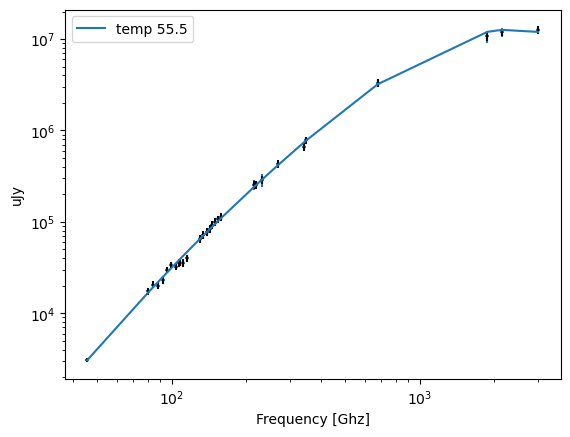

In [239]:
data_version, mcmc_nu, mcmc_Snu, mcmc_Snu_err,flux_scale_errors, flux_scale_errors_scaled = get_data_version('vis', True,0,0, 80)

fig, ax = plt.subplots(1,1)

ax.errorbar(mcmc_nu,mcmc_Snu,mcmc_Snu_err,fmt='none')

ax.errorbar(mcmc_nu,mcmc_Snu,flux_scale_errors_scaled,fmt='none',color='black')

ax.scatter(mcmc_nu,mcmc_Snu,s=10,marker='+')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency [Ghz]")
ax.set_ylabel("uJy")

# S0 = .5
# T = 60
# beta = 1.3

S0, T, beta = 0.27 ,  55.5, 1.35

plot_model(ax, S0 = S0, T=T, beta = beta, kappa0 = .6, vs = mcmc_nu)

ll = log_likelihood_thermal_model(np.array([S0, beta, T, 0]), mcmc_nu, mcmc_Snu, mcmc_Snu_err)

print(ll)

In [ ]:
-415271.22468458756


In [237]:
## plotting MCMC chains
def plot_chains(sampler,labels,ndim):

    chains_fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.axvline(x=.15*len(samples[:, :, i]),color='red',ls='--',alpha=.6)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()

    return chains_fig

def log_likelihood_thermal_model(thermal_params, v, Sv, Sv_err):

    ## chi = fraction of emission from contamination from brehmstralung
    Sigma0, beta0, T0, log_f = thermal_params 
    # print('params', (Sigma0, beta0, T0, log_f))

    # normalize to Ghz
    model_Sv, model_vs = model_wrapper(T=T0,beta=beta0, Sigma0 = Sigma0, vs = v)

    sigma2 = Sv_err**2 + model_Sv**2 * np.exp(2*log_f)
    # log_model = np.log(model)

    log_likelihood = -0.5 * np.sum((Sv - model_Sv) ** 2 / sigma2 + np.log(sigma2))


    # print(f'params: {thermal_params}. ll: {log_likelihood}')
    return log_likelihood

def log_prior_thermal_model(thermal_params):
    Sigma0, beta0, T0, log_f = thermal_params 
    if 0 < Sigma0 < 3 and 0 < beta0  < 2 and 10 < T0 < 200 and -50 < log_f < 50:
        return 0.0  # log(1) = 0 for flat prior
    return -np.inf  # log(0) = -inf for values outside the bounds

# Define the posterior probability function (log-posterior)
def log_posterior_thermal_model(single_contam_theta, x, y, sigma):
    lp = log_prior_thermal_model(single_contam_theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_thermal_model(single_contam_theta, x, y, sigma)


In [172]:
def run_mcmc(ndim, nu, Snu, Snu_err,nsteps=20000,walkers_scaling=10,scaling=1, burn_fraction=.15,plot=False):

    # Set up the MCMC sampler
    nwalkers = ndim*walkers_scaling  # number of walkers

    # Initialize walkers close to plausible values
    labels = ['Sigma0','beta','T0','log_f']
    initial_guess = np.array([0.5, 1.3, 60, 0])  # initial guesses for two component model
    
    initial_position = initial_guess + 0.1 * np.random.randn(nwalkers, ndim) 

    # normalize Nu Vis to Ghz
    norm_nu_vis = nu / (scaling)

    # Set up the emcee sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_thermal_model, args=(norm_nu_vis, Snu, Snu_err),a=2.5)

    # Run the MCMC
    sampler.run_mcmc(initial_position, int(nsteps/2), progress=True)

    samples = sampler.chain

    # Step 1: Calculate the overall mean of each parameter across all walkers and steps
    overall_mean = np.mean(samples, axis=(0, 1))  # Shape should be (n_dim,)

    # Step 2: Calculate the mean for each walker (average over n_steps for each walker)
    walker_means = np.mean(samples, axis=1)  # Shape should be (n_walkers, n_dim)

    # Step 3: Calculate the distance of each walker mean from the overall mean
    deviations = np.linalg.norm(walker_means - overall_mean, axis=1)
    # Step 4: Identify outlier walkers (e.g., threshold as 2 standard deviations from the mean deviation)
    threshold = 2 * np.std(deviations)

    outliers = deviations > threshold

    # Step 5: Filter out outlier walkers and set up new initial positions
    filtered_walkers = walker_means[~outliers]  # Keeps only non-outlier walkers

    # Step 6: Restart the emcee sampler with the filtered walkers as the new starting positions
    nwalkers_filtered, ndim = filtered_walkers.shape

    print(len(filtered_walkers), ndim)

    sampler = emcee.EnsembleSampler(nwalkers_filtered, ndim, log_posterior_thermal_model, args=(norm_nu_vis, Snu, Snu_err),a=2.5)

    sampler.run_mcmc(filtered_walkers, nsteps, progress=True)

    samples = sampler.get_chain(thin=15, flat=True)


    params = []

    for i in range(ndim):
        params.append(np.median(samples[int(np.round(len(samples)*burn_fraction)):, i]))

    samples = samples[int(np.round(len(samples)*burn_fraction)):, :]


    if plot:
        chains_fig = plot_chains(sampler,labels,ndim)
    # Assuming `samples` is your MCMC chain samples (shape: nsteps, nwalkers, ndim)
        flat_samples = samples.reshape((-1, ndim))  # Flatten if using an MCMC sampler like emcee
        corner_labels = ["$\\Sigma_0$", "$\\beta$", "$T_0", "log_f"] if ndim == 4 else labels
        corner_fig = corner.corner(flat_samples, labels=corner_labels, show_titles=True)
        corner_fig.show()

        return samples, sampler, params, norm_nu_vis, labels, chains_fig, corner_fig

    else:
        return samples, sampler, params, norm_nu_vis, labels

100%|██████████| 500/500 [08:52<00:00,  1.07s/it]


34 4


100%|██████████| 1000/1000 [17:06<00:00,  1.03s/it]


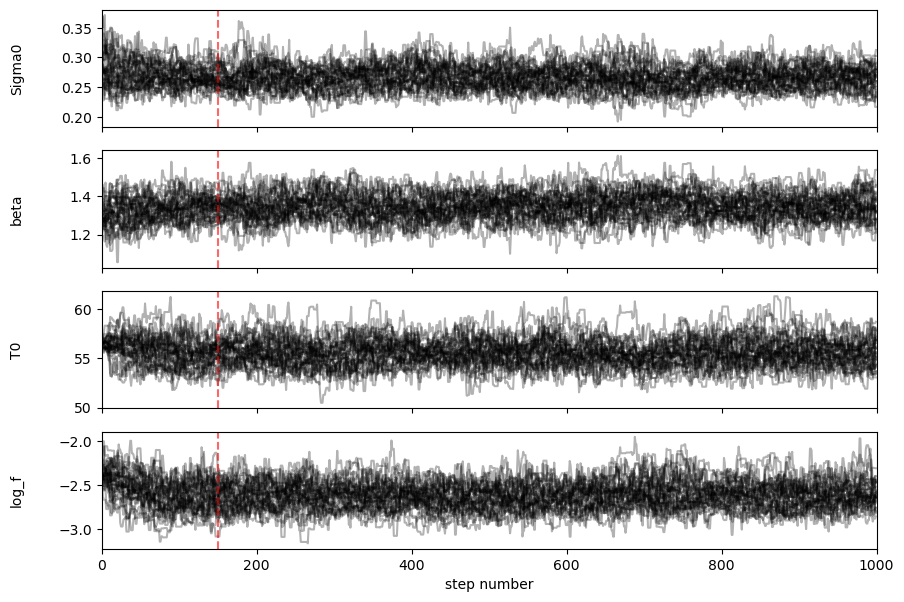

/var/folders/vy/3w_cyymn26g4jzqfnt1dv5xm0000gn/T/ipykernel_79568/2051514541.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_fig.show()


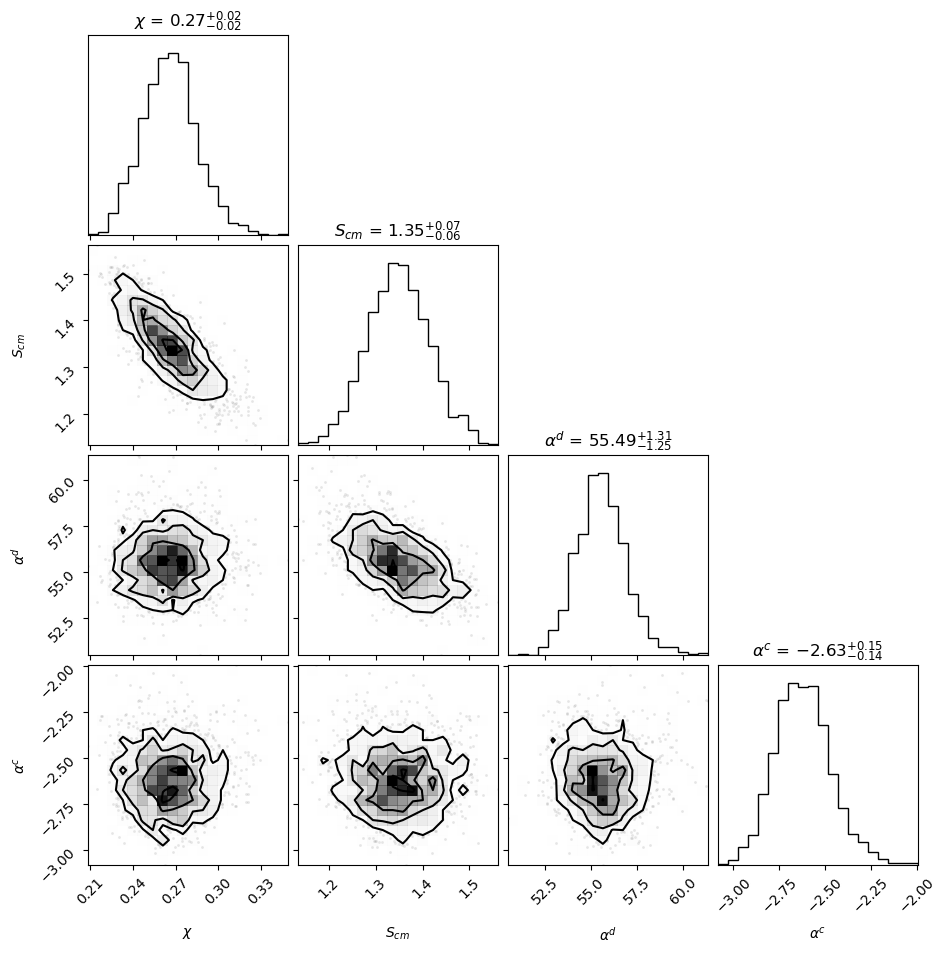

In [238]:
samples, sampler, params, norm_nu_vis, labels, chains_fig, corner_fig = run_mcmc(4, mcmc_nu,mcmc_Snu,mcmc_Snu_err,1000,10,1, plot=True)

In [ ]:
## check movement with different temperatures

## in part where you think you're thin, power law should be nu^2+beta

## can play with the actual opacities

## OPtool --> opacity spectrum for some parameters, Kirsten Dominic

## larger particles --> lower beta

# parameters with some physical grounding have reasoning

## write up bootstraping
## --> keep surface density fixed, and kappa fixed, but fit for Temperature

### --> adjust T0 and beta, and sigma0 --> fit for these

## maybe not worthing make more

## parameterize opacity calculation --> like maximum particle size, big grid --> 
## continuous distribution of ellipsoids

## playing with OPTools
## set up pipeline to fit on the data
## write up an outline for everything --> overleaf
## 

